In [1]:
from typing import Dict, Union

#model_general
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
from torch_geometric.data import Data
from torch_cluster import radius_graph
from torch_scatter import scatter

#e3nn
import e3nn
from e3nn import o3
from e3nn.math import soft_one_hot_linspace
from e3nn.nn import FullyConnectedNet, Gate
#from e3nn.nn.models.gate_points_2101 import Convolution, smooth_cutoff, tp_path_exists
from e3nn.o3 import TensorProduct, Linear, FullyConnectedTensorProduct
from e3nn.util.jit import compile_mode

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
from ase import io

#other
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import math
import time
from tqdm import tqdm
import numpy as np
bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
textsize = 14
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

## **I. Load data from Material Project**

In [2]:
from pymatgen.ext.matproj import MPRester

# Obtain your API key here: https://next-gen.materialsproject.org/api
mpr = MPRester(api_key="apCoLSrqYyRhKXHua7K5KUIYdsTlsNWd")
entries = mpr.get_entries_in_chemsys(["Si", "O"])
structures = [e.structure for e in entries]
energies = [e.energy for e in entries]
forces = [np.zeros((len(s), 3)).tolist() for s in structures]
stresses = [np.zeros((3, 3)).tolist() for s in structures]
labels = {
    "energies": energies,
    "forces": forces,
    "stresses": stresses,
}

print(f"{len(structures)} downloaded from MP.")

407 downloaded from MP.


In [3]:
dat = {'structure': [], 'energy':[] }
#dat['structure', 'energy'] = {}
for i in range(len(structures)):
    new = Atoms(symbols=structures[i].formula.replace(' ',''), positions=structures[i].cart_coords, 
                     cell=structures[i].lattice.matrix, pbc = structures[0].pbc[0])
    dat['structure'].append(new)

for i in range (len(entries)):
    dat['energy'].append(energies[i])

#convert energy
y_m = np.mean(dat['energy'])
y_std = np.std(dat['energy'])

dat['energy'] = (dat['energy']-y_m)/y_std

In [6]:
dat['structure'][2]

Atoms(symbols='Si8O16', pbc=True, cell=[[0.0, 7.722973, 10.383657], [2.47383, 0.0, 10.383657], [2.47383, 7.722973, 0.0]])

In [70]:
dat['energy']

array([-1.67605553,  0.0846645 ,  0.55668376, -0.56548432, -1.67517556,
        0.54625436,  0.43593843, -1.00452577,  0.71336089,  0.77199782,
       -2.3373395 , -0.34209369,  0.97959469, -1.66161156, -0.7861458 ,
        0.10214251,  0.1108951 , -0.34251454, -1.52234142,  0.90290984,
        0.98248293,  0.5748167 ,  0.87061464, -0.00795265, -0.36343851,
        0.71839318,  0.1216136 ,  0.94645897,  0.11684943, -0.78587352,
       -2.11941678, -0.342555  ,  0.77190028,  0.97969985,  0.10189173,
       -1.56544648,  0.1818599 , -0.34214826,  0.76828257,  0.34264102,
        0.65717117, -0.89738618,  0.32406839,  0.92141219,  0.02886412,
        0.38560929,  0.89727746, -0.34332129, -0.12070368, -1.63605073,
       -0.30469578, -5.6775074 ,  0.65780567,  0.65710246, -1.67598685,
        0.76849997,  0.51719119,  0.76818599, -0.65534997,  0.94682205,
       -1.734258  ,  0.10170217, -0.56531381,  0.5549202 ,  0.55566609,
        0.44766086, -0.89842105,  0.90320603,  0.1013602 , -0.34

In [68]:
dat['energy']

[-1204.28096469,
 -409.10791921000003,
 -195.93547882,
 -702.72689959,
 -1203.88355409,
 -200.64558072999998,
 -250.46625177,
 -901.0059665900001,
 -125.17724992000001,
 -98.69574731,
 -1502.9287798,
 -601.83964479,
 -4.9412459,
 -1197.75780396,
 -802.38161608,
 -401.2145354,
 -397.26170757,
 -602.02970927,
 -1134.86088697,
 -39.57350969,
 -3.63686277,
 -187.74631336,
 -54.15860544,
 -450.93550237000005,
 -611.4793508,
 -122.90457683,
 -392.42103826,
 -19.90593659,
 -394.57262307999997,
 -802.25865355,
 -1404.5109321099999,
 -602.04798187,
 -98.7397992,
 -4.89375202,
 -401.3277918,
 -1154.3279149999998,
 -365.21271745,
 -601.86428997,
 -100.37362132,
 -292.60105189,
 -150.55354378,
 -852.61978776,
 -300.98878836,
 -31.21751653,
 -434.30838375,
 -273.19580475,
 -42.11719544,
 -602.39405199,
 -501.85591035000004,
 -1186.2140731,
 -584.95007345,
 -3011.40907361,
 -150.26699137,
 -150.58457189,
 -1204.24994728,
 -100.27544146,
 -213.77103704,
 -100.41724131999999,
 -743.3118525,
 -19.74196

<Axes: >

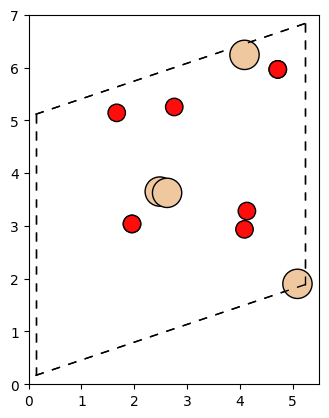

In [8]:
plot_atoms(dat['structure'][6], radii=0.25, rotation=('0x, 90y,0z'))

## **II. One-hot encoding**

In [9]:
type_encoding = {}

for Z in tqdm(range(1, 119), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1

type_onehot = torch.eye(len(type_encoding))

100%|██████████| 118/118 [00:00<00:00, 165030.97it/s]


In [11]:
type_encoding['Si']

13

In [12]:
type_onehot[type_encoding['Si']]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
type_onehot[type_encoding['Si']].size()

torch.Size([118])

## **III. Build data**

In [48]:
# build data
def build_data(entry, target, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.symbols).copy()
    positions = torch.from_numpy(entry.positions.copy())
    lattice = torch.from_numpy(entry.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
        z= positions.new_ones((positions.shape[0], 118)),
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        energy=torch.tensor(target).unsqueeze(0)
    )
    
    return data

In [49]:
r_max = 4. # cutoff radius
data = []
for i in range (len(entries)):
    data.append(build_data(dat['structure'][i], dat['energy'][i], type_encoding, type_onehot, r_max))

In [49]:
len(data)

407

In [54]:
data[6]

Data(x=[12, 118], edge_index=[2, 270], pos=[12, 3], lattice=[1, 3, 3], symbol=[12], z=[12, 118], edge_shift=[270, 3], edge_vec=[270, 3], edge_len=[270], energy=[1])

In [29]:
data[6]['energy']

tensor([0.7759])

In [30]:
data[6]['edge_index']

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9,  9,

## **IV. Visualize Crystal Graph**

In [16]:
palette = ['#2876B2', '#F39957', '#67C7C2', '#C86646']
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])
fontsize = 14

def plot_example(df, i=0, label_edges=False):
    # plot an example crystal structure and graph
    entry = df[i]

    # get graph with node and edge attributes
    g = tg.utils.to_networkx(entry, node_attrs=['symbol'], edge_attrs=['edge_len'], to_undirected=True)

    # remove self-loop edges for plotting
    g.remove_edges_from(list(nx.selfloop_edges(g)))
    node_labels = dict(zip([k[0] for k in g.nodes.data()], [k[1]['symbol'] for k in g.nodes.data()]))
    edge_labels = dict(zip([(k[0], k[1]) for k in g.edges.data()], [k[2]['edge_len'] for k in g.edges.data()]))

    # project positions of nodes to 2D for plotting
    pos = dict(zip(list(g.nodes), [np.roll(k,2)[:-1][::-1] for k in entry.pos.numpy()]))

    # plot unit cell
    fig, ax = plt.subplots(1,2, figsize=(18,14), gridspec_kw={'width_ratios': [2,3]})
    atoms = Atoms(symbols=entry.symbol, positions=entry.pos.numpy(), cell=entry.lattice.squeeze().numpy(), pbc=True)
    symbols = np.unique(entry.symbol)
    z = dict(zip(symbols, range(len(symbols))))
    norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
    color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in entry.symbol]))]
    plot_atoms(atoms, ax[0], radii=0.25, colors=color, rotation=('0x,90y,0z'))

    # plot graph
    nx.draw_networkx(g, ax=ax[1], labels=node_labels, pos=pos, node_size=200, node_color=color,
                     edge_color='gray')
    
    if label_edges:
        nx.draw_networkx_edge_labels(g, ax=ax[1], edge_labels=edge_labels, pos=pos, label_pos=0.5)
    
    # format axes
    ax[0].set_xlabel(r'$x_1\ (\AA)$')
    ax[0].set_ylabel(r'$x_2\ (\AA)$')
    ax[0].set_title('Crystal structure', fontsize=fontsize)
    ax[1].set_aspect('equal')
    ax[1].axis('off')
    ax[1].set_title('Crystal graph', fontsize=fontsize)
    pad = np.array([-0.5, 0.5])
    ax[1].set_xlim(np.array(ax[1].get_xlim()) + pad)
    ax[1].set_ylim(np.array(ax[1].get_ylim()) + pad)
    fig.subplots_adjust(wspace=0.4)

ValueError: too many values to unpack (expected 3)

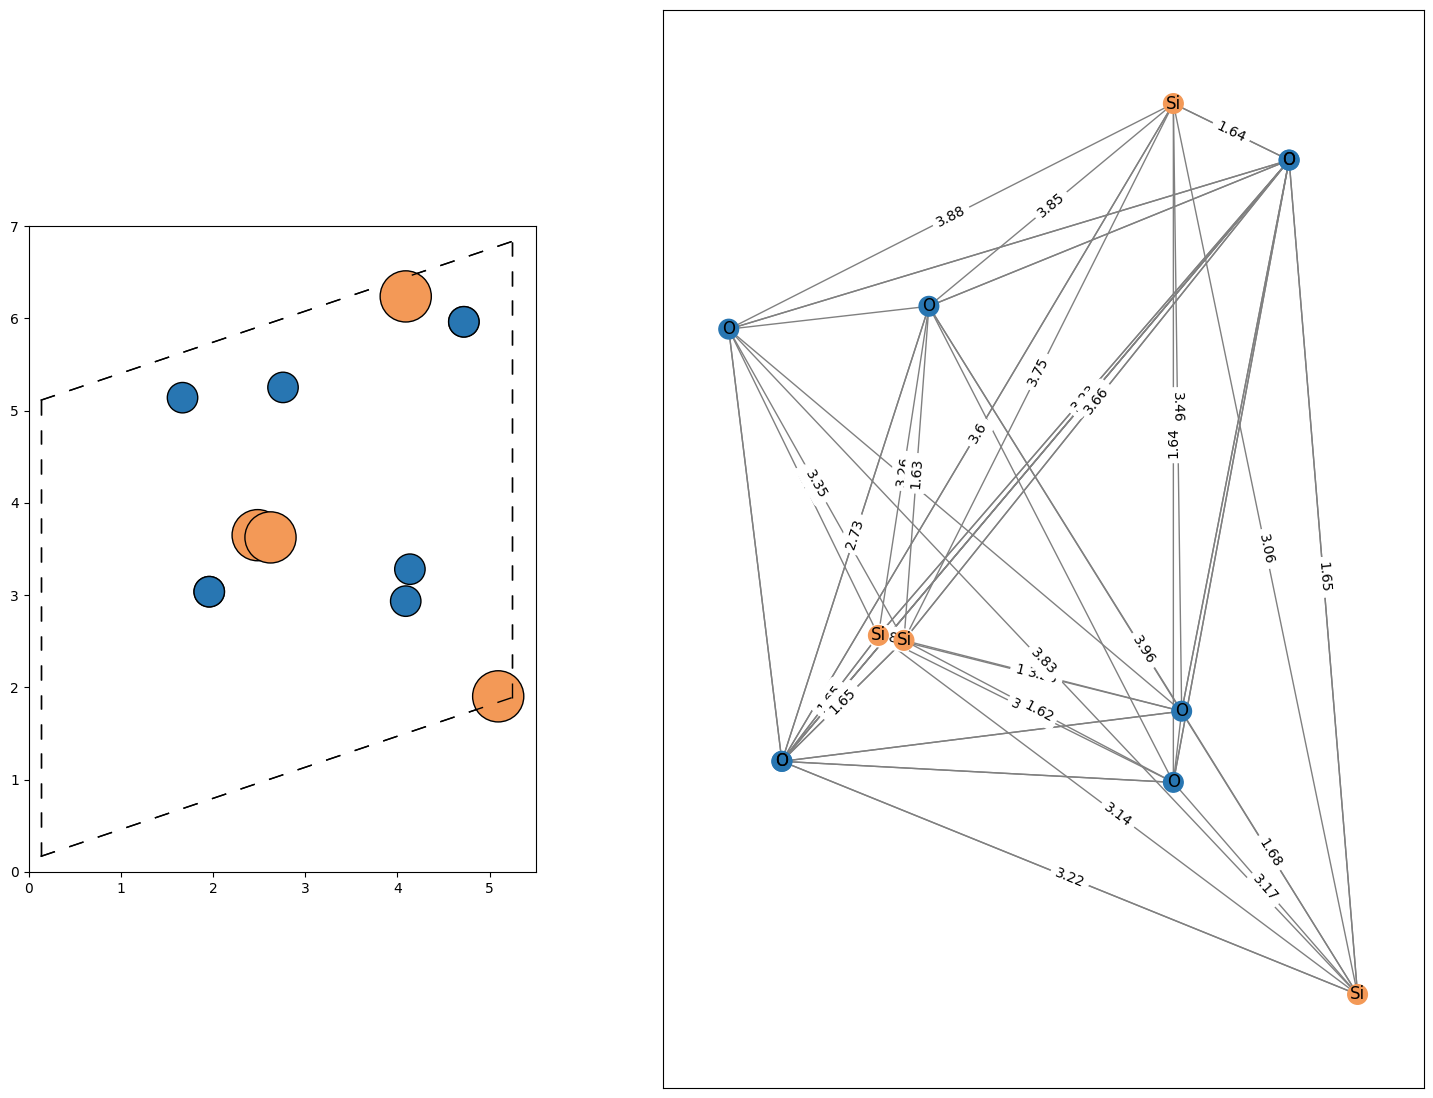

In [17]:
plot_example(data, 6, label_edges=True)

## **Train-Valid-Test split data**

In [55]:
from sklearn.model_selection import train_test_split

def split(dat, train_size, valid_size, test_size, seed = 12):
    d_train, d_mid = train_test_split(data, train_size=train_size)
    d_val, d_test = train_test_split(d_mid, test_size = test_size/(test_size + valid_size))
    return d_train, d_val, d_test

d_train, d_val, d_test = split(data, train_size=0.8, valid_size=0.1, test_size=0.1)

In [56]:
print(len(d_train), len(d_val), len(d_test))

325 41 41


In [57]:
d_test[0].values()

ValuesView({'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'edge_index': tensor([[ 0,  0,  0,  ..., 47, 47, 47],
        [22, 25, 46,  ..., 39,  2, 47]]), 'pos': tensor([[ 3.6777e+00,  8.5029e+00,  2.9463e+00],
        [ 5.6476e+00,  3.6777e+00,  2.9463e+00],
        [ 3.3975e+00,  1.4276e+00,  6.1188e+00],
        [-1.4276e+00,  3.3975e+00,  6.1188e+00],
        [ 8.5029e+00,  3.6777e+00,  1.5862e+00],
        [ 3.6777e+00,  5.6476e+00,  1.5862e+00],
        [ 3.6777e+00,  5.6476e+00, -1.5862e+00],
        [ 8.5029e+00,  3.6777e+00, -1.5862e+00],
        [ 3.3975e+00, -1.4276e+00,  1.5862e+00],
        [-1.4276e+00,  1.0753e+01,  1.5862e+00],
        [ 3.3975e+00,  1.4276e+00,  2.9463e+00],
        [-3.6777e+00,  5.6476e+00,  2.9463e+00],
        [ 1.0753e+01,  1.4276e+00,  1

## **Interaction Block**

In [32]:
class Convolution(torch.nn.Module):
    r"""equivariant convolution

    Parameters
    ----------
    irreps_in : `e3nn.o3.Irreps`
        representation of the input node features

    irreps_node_attr : `e3nn.o3.Irreps`
        representation of the node attributes

    irreps_edge_attr : `e3nn.o3.Irreps`
        representation of the edge attributes

    irreps_out : `e3nn.o3.Irreps` or None
        representation of the output node features

    number_of_basis : int
        number of basis on which the edge length are projected

    radial_layers : int
        number of hidden layers in the radial fully connected network

    radial_neurons : int
        number of neurons in the hidden layers of the radial fully connected network

    num_neighbors : float
        typical number of nodes convolved over
    """
    def __init__(
        self,
        irreps_in,
        irreps_node_attr,
        irreps_edge_attr,
        irreps_out,
        number_of_basis,
        radial_layers,
        radial_neurons,
        num_neighbors=None
    ) -> None:
        super().__init__()
        self.irreps_in = o3.Irreps(irreps_in)
        self.irreps_node_attr = o3.Irreps(irreps_node_attr)
        self.irreps_edge_attr = o3.Irreps(irreps_edge_attr)
        self.irreps_out = o3.Irreps(irreps_out)
        self.num_neighbors = num_neighbors

        self.sc = FullyConnectedTensorProduct(self.irreps_in, self.irreps_node_attr, self.irreps_out)

        #self.lin1 = FullyConnectedTensorProduct(self.irreps_in, self.irreps_node_attr, self.irreps_in)

        self.lin1 = Linear(
            irreps_in=self.irreps_in,
            irreps_out=self.irreps_in,
            internal_weights=True,
            shared_weights=True,
        )
        
        irreps_mid = []
        instructions = []
        for i, (mul, ir_in) in enumerate(self.irreps_in):
            for j, (_, ir_edge) in enumerate(self.irreps_edge_attr):
                for ir_out in ir_in * ir_edge:
                    if ir_out in self.irreps_out:
                        k = len(irreps_mid)
                        irreps_mid.append((mul, ir_out))
                        instructions.append((i, j, k, 'uvu', True))
                        
        irreps_mid = o3.Irreps(irreps_mid)
        irreps_mid, p, _ = irreps_mid.sort()

        instructions = [
            (i_1, i_2, p[i_out], mode, train)
            for i_1, i_2, i_out, mode, train in instructions
        ]

        tp = TensorProduct(
            self.irreps_in,
            self.irreps_edge_attr,
            irreps_mid,
            instructions,
            internal_weights=False,
            shared_weights=False,
        )
        self.fc = FullyConnectedNet([number_of_basis] + radial_layers * [radial_neurons] + [tp.weight_numel], torch.nn.functional.silu)
        self.tp = tp

        #self.lin2 = FullyConnectedTensorProduct(irreps_mid, self.irreps_node_attr, self.irreps_out)
        
        self.lin2 = Linear(
            # irreps_mid has uncoallesed irreps because of the uvu instructions,
            # but there's no reason to treat them seperately for the Linear
            # Note that normalization of o3.Linear changes if irreps are coallesed
            # (likely for the better)
            irreps_in=irreps_mid.simplify(),
            irreps_out=self.irreps_out,
            internal_weights=True,
            shared_weights=True,
        )
        
    
    def forward(self, node_input, node_attr, edge_src, edge_dst, edge_attr, edge_length_embedded) -> torch.Tensor:
        weight = self.fc(edge_length_embedded)

        x = node_input

        s = self.sc(x, node_attr)
        #x = self.lin1(x,node_attr)
        x = self.lin1(x)
        
        edge_features = self.tp(x[edge_src], edge_attr, weight)

        avg_num_neigh: Optional[float] = self.num_neighbors
        if avg_num_neigh is not None:
            edge_features = edge_features.div(avg_num_neigh**0.5)
        
        x = scatter(edge_features, edge_dst, dim=0, dim_size=x.shape[0])

        #x = self.lin2(x, node_attr)
        x = self.lin2(x)

        #c_s, c_x = math.sin(math.pi / 8), math.cos(math.pi / 8)
        #m = self.sc.output_mask
        #c_x = (1 - m) + c_x * m
        #return c_s * s + c_x * x
        return x + s

In [33]:
def tp_path_exists(irreps_in1, irreps_in2, ir_out):
    irreps_in1 = o3.Irreps(irreps_in1).simplify()
    irreps_in2 = o3.Irreps(irreps_in2).simplify()
    ir_out = o3.Irrep(ir_out)

    for _, ir1 in irreps_in1:
        for _, ir2 in irreps_in2:
            if ir_out in ir1 * ir2:
                return True
    return False

In [34]:
def smooth_cutoff(x):
    u = 2 * (x - 1)
    y = (math.pi * u).cos().neg().add(1).div(2)
    y[u > 0] = 0
    y[u < -1] = 1
    return y

In [35]:
# Polynomial Cutoff

def _poly_cutoff(x: torch.Tensor, factor: float, p: float = 6.0) -> torch.Tensor:
    x = x * factor

    out = 1.0
    out = out - (((p + 1.0) * (p + 2.0) / 2.0) * torch.pow(x, p))
    out = out + (p * (p + 2.0) * torch.pow(x, p + 1.0))
    out = out - ((p * (p + 1.0) / 2) * torch.pow(x, p + 2.0))

    return out * (x < 1.0)

class PolynomialCutoff(torch.nn.Module):
    _factor: float
    p: float

    def __init__(self, r_max: float, p: float = 6):
        r"""Polynomial cutoff, as proposed in DimeNet: https://arxiv.org/abs/2003.03123


        Parameters
        ----------
        r_max : float
            Cutoff radius

        p : int
            Power used in envelope function
        """
        super().__init__()
        assert p >= 2.0
        self.p = float(p)
        self._factor = 1.0 / float(r_max)

    def forward(self, x):
        """
        Evaluate cutoff function.

        x: torch.Tensor, input distance
        """
        return _poly_cutoff(x, self._factor, p=self.p)

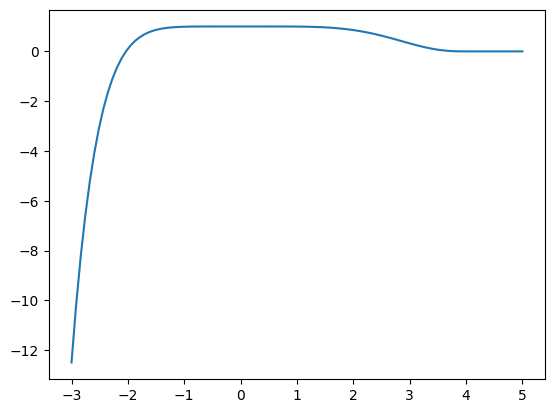

In [40]:
x = torch.linspace(-3,5,100)
plt.plot(x,PolynomialCutoff(4, p = 6)(x))
plt.show()

In [40]:
# Convolution network for message passing


class CustomCompose(torch.nn.Module):
    def __init__(self, first, second):
        super().__init__()
        self.first = first
        self.second = second
        self.irreps_in = self.first.irreps_in
        self.irreps_out = self.second.irreps_out

    def forward(self, *input):
        x = self.first(*input)
        self.first_out = x.clone()
        x = self.second(x)
        self.second_out = x.clone()
        return x

class Network(torch.nn.Module):
    r"""equivariant neural network
    Parameters
    ----------
    irreps_in : `e3nn.o3.Irreps` or None
        representation of the input features
        can be set to ``None`` if nodes don't have input features
    irreps_hidden : `e3nn.o3.Irreps`
        representation of the hidden features
    irreps_out : `e3nn.o3.Irreps`
        representation of the output features
    irreps_node_attr : `e3nn.o3.Irreps` or None
        representation of the nodes attributes
        can be set to ``None`` if nodes don't have attributes
    irreps_edge_attr : `e3nn.o3.Irreps`
        representation of the edge attributes
        the edge attributes are :math:`h(r) Y(\vec r / r)`
        where :math:`h` is a smooth function that goes to zero at ``max_radius``
        and :math:`Y` are the spherical harmonics polynomials
    layers : int
        number of gates (non linearities)
    max_radius : float
        maximum radius for the convolution
    number_of_basis : int
        number of basis on which the edge length are projected
    radial_layers : int
        number of hidden layers in the radial fully connected network
    radial_neurons : int
        number of neurons in the hidden layers of the radial fully connected network
    num_neighbors : float
        typical number of nodes at a distance ``max_radius``
    num_nodes : float
        typical number of nodes in a graph
    """
    def __init__(
        self,
        irreps_in,
        irreps_out,
        irreps_node_attr,
        layers,
        mul,
        lmax,
        max_radius,
        number_of_basis=10,
        radial_layers=1,
        radial_neurons=100,
        num_neighbors=1.,
        num_nodes=1.,
        reduce_output=True,
    ) -> None:
        super().__init__()
        self.mul = mul
        self.lmax = lmax
        self.max_radius = max_radius
        self.number_of_basis = number_of_basis
        self.num_neighbors = num_neighbors
        self.num_nodes = num_nodes
        self.reduce_output = reduce_output

        self.irreps_in = o3.Irreps(irreps_in) if irreps_in is not None else None
        self.irreps_hidden = o3.Irreps([(self.mul, (l, p)) for l in range(lmax + 1) for p in [-1, 1]])
        self.irreps_out = o3.Irreps(irreps_out)
        self.irreps_node_attr = o3.Irreps(irreps_node_attr) if irreps_node_attr is not None else o3.Irreps("0e")
        self.irreps_edge_attr = o3.Irreps.spherical_harmonics(lmax)

        self.input_has_node_in = (irreps_in is not None)
        self.input_has_node_attr = (irreps_node_attr is not None)

        irreps = self.irreps_in if self.irreps_in is not None else o3.Irreps("0e")

        act = {
            1: torch.nn.functional.silu,
            -1: torch.tanh,
        }
        act_gates = {
            1: torch.nn.functional.silu,
            -1: torch.tanh,
        }

        self.layers = torch.nn.ModuleList()

        for _ in range(layers):
            irreps_scalars = o3.Irreps([(mul, ir) for mul, ir in self.irreps_hidden if ir.l == 0 and tp_path_exists(irreps, self.irreps_edge_attr, ir)])
            irreps_gated = o3.Irreps([(mul, ir) for mul, ir in self.irreps_hidden if ir.l > 0 and tp_path_exists(irreps, self.irreps_edge_attr, ir)])
            ir = "0e" if tp_path_exists(irreps, self.irreps_edge_attr, "0e") else "0o"
            irreps_gates = o3.Irreps([(mul, ir) for mul, _ in irreps_gated])

            gate = Gate(
                irreps_scalars, [act[ir.p] for _, ir in irreps_scalars],  # scalar
                irreps_gates, [act_gates[ir.p] for _, ir in irreps_gates],  # gates (scalars)
                irreps_gated  # gated tensors
            )
            conv = Convolution(
                irreps,
                self.irreps_node_attr,
                self.irreps_edge_attr,
                gate.irreps_in,
                number_of_basis,
                radial_layers,
                radial_neurons,
                num_neighbors
            )
            irreps = gate.irreps_out
            self.layers.append(CustomCompose(conv, gate))

        self.layers.append(
            Convolution(
                irreps,
                self.irreps_node_attr,
                self.irreps_edge_attr,
                self.irreps_out,
                number_of_basis,
                radial_layers,
                radial_neurons,
                num_neighbors
            )
        )

    def preprocess(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        if 'edge_index' in data:
            edge_src = data['edge_index'][0]  # edge source
            edge_dst = data['edge_index'][1]  # edge destination
            edge_vec = data['edge_vec']
        
        else:
            edge_index = radius_graph(data['pos'], self.max_radius, batch)
            edge_src = edge_index[0]
            edge_dst = edge_index[1]
            edge_vec = data['pos'][edge_src] - data['pos'][edge_dst]

        return batch, edge_src, edge_dst, edge_vec

    def forward(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        """evaluate the network
        Parameters
        ----------
        data : `torch_geometric.data.Data` or dict
            data object containing
            - ``pos`` the position of the nodes (atoms)
            - ``x`` the input features of the nodes, optional
            - ``z`` the attributes of the nodes, for instance the atom type, optional
            - ``batch`` the graph to which the node belong, optional
        """
        batch, edge_src, edge_dst, edge_vec = self.preprocess(data)
        edge_sh = o3.spherical_harmonics(self.irreps_edge_attr, edge_vec, True, normalization='component')
        edge_length = edge_vec.norm(dim=1)
        edge_length_embedded = soft_one_hot_linspace(
            x=edge_length,
            start=0.0,
            end=self.max_radius,
            number=self.number_of_basis,
            basis='gaussian',
            cutoff=False
        ).mul(self.number_of_basis**0.5)
        edge_attr = smooth_cutoff(edge_length / self.max_radius)[:, None] * edge_sh

        if self.input_has_node_in and 'x' in data:
            assert self.irreps_in is not None
            x = data['x']
        else:
            assert self.irreps_in is None
            x = data['pos'].new_ones((data['pos'].shape[0], 118))

        if self.input_has_node_attr and 'z' in data:
            z = data['z']
        else:
            #assert self.irreps_node_attr == o3.Irreps("0e")
            assert self.input_has_node_attr is None
            z = data['pos'].new_ones((data['pos'].shape[0], 118))

        for lay in self.layers:
            x = lay(x, z, edge_src, edge_dst, edge_attr, edge_length_embedded)

        if self.reduce_output:
            return scatter(x, batch, dim=0).div(self.num_nodes**0.5)
        else:
            return x


def visualize_layers(model):
    layer_dst = dict(zip(['sc', 'lin1', 'tp', 'lin2'], ['gate', 'tp', 'lin2', 'gate']))
    try: layers = model.mp.layers
    except: layers = model.layers

    num_layers = len(layers)
    num_ops = max([len([k for k in list(layers[i].first._modules.keys()) if k not in ['fc', 'alpha']])
                   for i in range(num_layers-1)])

    fig, ax = plt.subplots(num_layers, num_ops, figsize=(14,3.5*num_layers))
    for i in range(num_layers - 1):
        ops = layers[i].first._modules.copy()
        ops.pop('fc', None); ops.pop('alpha', None)
        for j, (k, v) in enumerate(ops.items()):
            ax[i,j].set_title(k, fontsize=textsize)
            v.cpu().visualize(ax=ax[i,j])
            ax[i,j].text(0.7,-0.15,'--> to ' + layer_dst[k], fontsize=textsize-2, transform=ax[i,j].transAxes)

    layer_dst = dict(zip(['sc', 'lin1', 'tp', 'lin2'], ['output', 'tp', 'lin2', 'output']))
    ops = layers[-1]._modules.copy()
    ops.pop('fc', None); ops.pop('alpha', None)
    for j, (k, v) in enumerate(ops.items()):
        ax[-1,j].set_title(k, fontsize=textsize)
        v.cpu().visualize(ax=ax[-1,j])
        ax[-1,j].text(0.7,-0.15,'--> to ' + layer_dst[k], fontsize=textsize-2, transform=ax[-1,j].transAxes)

    fig.subplots_adjust(wspace=0.3, hspace=0.5)

## ***TEST***
 ****************************************************************************

In [58]:
d = data[6]
lin = nn.Linear(118, 32)
d.x = lin(d.x)
d.z = lin(d.z)

In [63]:
netw = Network(irreps_in="32x0e", irreps_out="0e", irreps_node_attr="32x0e", layers=2, mul=32, lmax=1, max_radius=2)
netw.preprocess(d)

/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  

In [64]:
netw(d)

tensor([[-0.6789]], grad_fn=<DivBackward0>)

In [45]:
batch, edge_src, edge_dst, edge_vec = netw.preprocess(d)
edge_sh = o3.spherical_harmonics(netw.irreps_edge_attr, edge_vec, True, normalization='component')
edge_length = edge_vec.norm(dim=1)
edge_length_embedded = soft_one_hot_linspace(
            x=edge_length,
            start=0.0,
            end=netw.max_radius,
            number=netw.number_of_basis,
            basis='gaussian',
            cutoff=False
).mul(netw.number_of_basis**0.5)
edge_attr = smooth_cutoff(edge_length / netw.max_radius)[:, None] * edge_sh

x = d['pos'].new_ones((d['pos'].shape[0], 118))
z = d['z']

x,z

(tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [31]:
x.size()

torch.Size([24, 118])

In [46]:
lin = nn.Linear(118, 32)
z = lin(d.z)
x = lin(x)
x,z

(tensor([[ 0.1595, -0.3246, -0.3626,  0.4556,  0.0053,  0.1227,  0.4894, -0.7327,
           0.1376, -0.3883, -1.2041, -0.2004,  1.1426,  0.4842,  0.6291, -0.3409,
          -0.6418, -0.6450, -0.2549,  0.4420, -0.2254, -0.2736,  0.0557,  1.0107,
           0.2387,  0.2479,  0.1849,  1.3957,  0.4513, -0.5929,  0.3419,  0.9584],
         [ 0.1595, -0.3246, -0.3626,  0.4556,  0.0053,  0.1227,  0.4894, -0.7327,
           0.1376, -0.3883, -1.2041, -0.2004,  1.1426,  0.4842,  0.6291, -0.3409,
          -0.6418, -0.6450, -0.2549,  0.4420, -0.2254, -0.2736,  0.0557,  1.0107,
           0.2387,  0.2479,  0.1849,  1.3957,  0.4513, -0.5929,  0.3419,  0.9584],
         [ 0.1595, -0.3246, -0.3626,  0.4556,  0.0053,  0.1227,  0.4894, -0.7327,
           0.1376, -0.3883, -1.2041, -0.2004,  1.1426,  0.4842,  0.6291, -0.3409,
          -0.6418, -0.6450, -0.2549,  0.4420, -0.2254, -0.2736,  0.0557,  1.0107,
           0.2387,  0.2479,  0.1849,  1.3957,  0.4513, -0.5929,  0.3419,  0.9584],
         [ 0.

In [47]:
#sc= FullyConnectedTensorProduct(self.irreps_in, self.irreps_node_attr, self.irreps_out)
sc_test= FullyConnectedTensorProduct(irreps_in1="32x0e", irreps_in2="32x0e", irreps_out="0e")
sc_test(x,z)

/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


tensor([[-1.3690e-06],
        [-1.3690e-06],
        [-1.3690e-06],
        [-1.3690e-06],
        [-1.3690e-06],
        [-1.3690e-06],
        [-1.3690e-06],
        [-1.3690e-06],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02],
        [ 1.4003e-02]], grad_fn=<ViewBackward0>)

In [ ]:
#l1 = FullyConnectedTensorProduct(self.irreps_in, self.irreps_node_attr, self.irreps_in)
l1 = FullyConnectedTensorProduct("32x0e", "32x0e", "32x0e")
l1

In [48]:
irreps_edge_attr = o3.Irreps.spherical_harmonics(1)

convl = Convolution(irreps_in="32x0e",
        irreps_node_attr="32x0e",
        irreps_edge_attr=irreps_edge_attr,
        irreps_out="0e",
        number_of_basis=10,
        radial_layers=1,
        radial_neurons=100,
        num_neighbors=1)
convl(x,z, edge_src, edge_dst, edge_attr, edge_length_embedded)

/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn

tensor([[ 0.5288],
        [ 0.6015],
        [ 0.5001],
        [ 0.6761],
        [ 0.6549],
        [ 0.4984],
        [ 0.7778],
        [ 0.6596],
        [-0.2233],
        [ 0.1593],
        [-0.1371],
        [ 0.0238],
        [-0.1952],
        [ 0.0261],
        [-0.1471],
        [ 0.1501],
        [ 0.1430],
        [-0.0326],
        [-0.0916],
        [-0.1786],
        [ 0.1440],
        [ 0.0978],
        [ 0.1263],
        [-0.0771]], grad_fn=<AddBackward0>)

*****

In [65]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        # embed the one-hot encoding
        self.em = nn.Linear(in_dim, em_dim)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.x = F.relu(self.em(data.x))
        data.z = F.relu(self.em(data.z))
        output = super().forward(data)
        output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
        
        maxima, _ = torch.max(output, dim=1)
        output = output.div(maxima.unsqueeze(1))
        
        return output

In [66]:
out_dim = 1
em_dim = 64  
r_max = 5
n_train = 5

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=2,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=1,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=5, #num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)

/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn

PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e+32x1o | 262144 paths | 262144 weights)
        (lin1): Linear(64x0e -> 64x0e | 4096 weights)
        (fc): FullyConnectedNet[10, 100, 128]
        (tp): TensorProduct(64x0e x 1x0e+1x1o -> 64x0e+64x1o | 128 paths | 128 weights)
        (lin2): Linear(64x0e+64x1o -> 64x0e+32x1o | 6144 weights)
      )
      (second): Gate (64x0e+32x1o -> 32x0e+32x1o)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 96x0e+32x1o+32x1e | 262144 paths | 262144 weights)
        (lin1): Linear(32x0e+32x1o -> 32x0e+32x1o | 2048 weights)
        (fc): FullyConnectedNet[10, 100, 160]
        (tp): TensorProduct(32x0e+32x1o x 1x0e+1x1o -> 64x0e+64x1o+32x1e | 160 paths | 160 weights)
        (lin2): Linear(64x0e+64x1o+32x1e -> 96x0e+32x1o+32x1e | 9216 weights)
      )
      (second): Gat

/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn

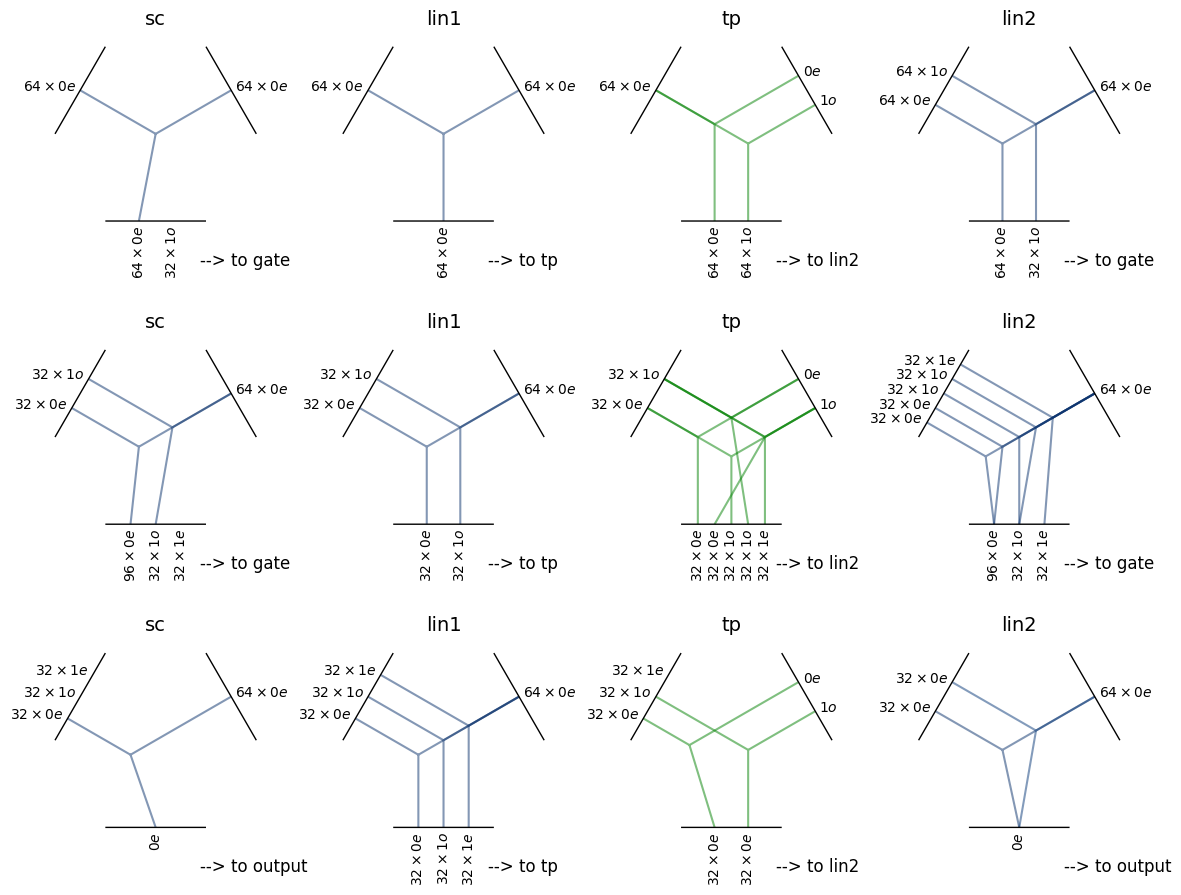

In [66]:
visualize_layers(model)

In [69]:
data[9]

Data(x=[72, 118], edge_index=[2, 972], pos=[72, 3], lattice=[1, 3, 3], symbol=[72], z=[72, 118], edge_shift=[972, 3], edge_vec=[972, 3], edge_len=[972], energy=[1])

In [67]:
d1 = tg.loader.DataLoader(data[9].values())

In [71]:
d1['structure']

TypeError: 'DataLoader' object is not subscriptable

In [72]:
model(data[6])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (12x32 and 118x64)

## ***Training*** 